## Importing Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
from skimage import exposure
from skimage.color import rgb2gray
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt
from random import Random
from skimage.feature import hog
from sklearn.svm import SVC,LinearSVC 
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,precision_score,accuracy_score,log_loss,f1_score,recall_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import tensorflow_hub as hub
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pickle
import json


In [2]:
# For fast code autocompletion
%config Completer.use_jedi = False

## Loading the Dataset

In [3]:
# Loading masked images from RMFD Dataset

masked_img = []
path = "D:\\ML\\USC\\Project\\RMFD\\self-built-masked-face-recognition-dataset\\AFDB_masked_face_dataset"
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for img in os.listdir(folder_path):
        if img.endswith(".jpg"):
            image = load_img(os.path.join(folder_path, img), target_size = (128,128))
            masked_img.append(img_to_array(image)/255.)
y_masked = [1]*len(masked_img)

In [4]:
# Loading face images from RMFD Dataset

face_img = []
path = "D:\\ML\\USC\\Project\\RMFD\\self-built-masked-face-recognition-dataset\\AFDB_face_dataset"
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for img in os.listdir(folder_path):
        if img.endswith(".jpg"):
            image = load_img(os.path.join(folder_path, img), target_size = (128,128))
            face_img.append(img_to_array(image)/255.)
        if(len(face_img)>=10000):
            break
    if(len(face_img)>=10000):
        break
Random(1).shuffle(face_img)
face_img = face_img[:len(masked_img)]
y_face = [0]*len(face_img)

In [5]:
## No. of images belonging to each category
len(masked_img),len(face_img)

(2118, 2118)

In [6]:
# Loading masked images from Real-Time-Medical-Mask-Detection Dataset

t_masked_img = []
path = "D:\\ML\\USC\\Project\\Dataset\\with_mask"
for img in os.listdir(path):
    if img.endswith(".jpg"):
        try:
            image = load_img(os.path.join(path, img), target_size = (128,128))
            t_masked_img.append(img_to_array(image)/255.)
        except: _ = 1
t_y_masked = [1]*len(t_masked_img)
masked_img = masked_img + t_masked_img
y_masked = y_masked + t_y_masked

C:\ProgramData\Anaconda3\envs\ml-env\lib\site-packages\PIL\Image.py:2957: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


In [7]:
# Loading face images from Real-Time-Medical-Mask-Detection Dataset

t_face_img = []
path = "D:\\ML\\USC\\Project\\Dataset\\without_mask"
for img in os.listdir(path):
    if img.endswith(".jpg"):
        try:
            image = load_img(os.path.join(path, img), target_size = (128,128))
            t_face_img.append(img_to_array(image)/255.)
        except:  _ = 1
t_face_img = t_face_img[:len(masked_img)]
t_y_face = [0]*len(t_face_img)
face_img = face_img + t_face_img
y_face = y_face + t_y_face

In [8]:
## No. of images belonging to each category

len(t_masked_img),len(t_face_img)

(5413, 5521)

In [9]:
## Total No. of images belonging to each category

len(masked_img),len(face_img)

(7531, 7639)

## Plotting Images and HOG Features

In [10]:
# Function to plot images

def plt_img(img_arr):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_arr[i])
    plt.tight_layout()
#     plt.savefig("data_pics")
    plt.show()

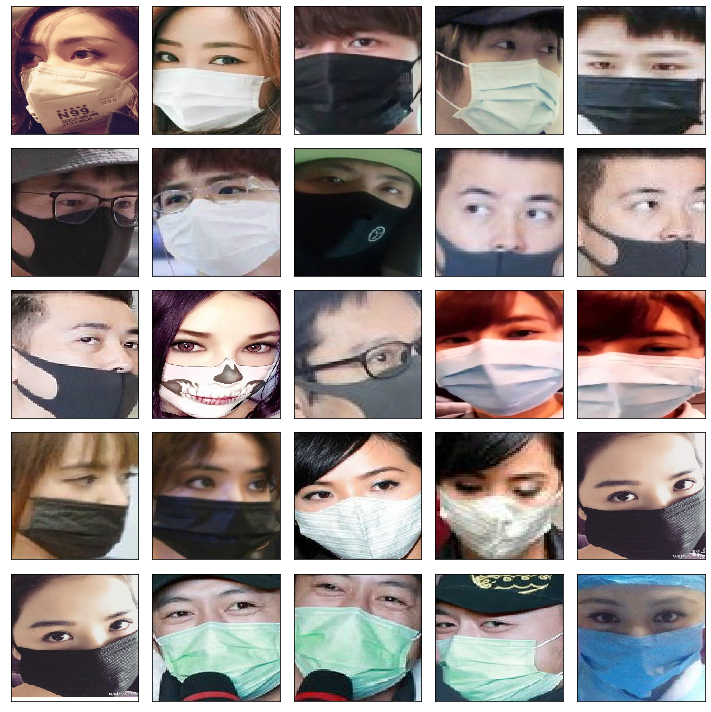

In [11]:
# Plotting masked images
plt_img(masked_img)

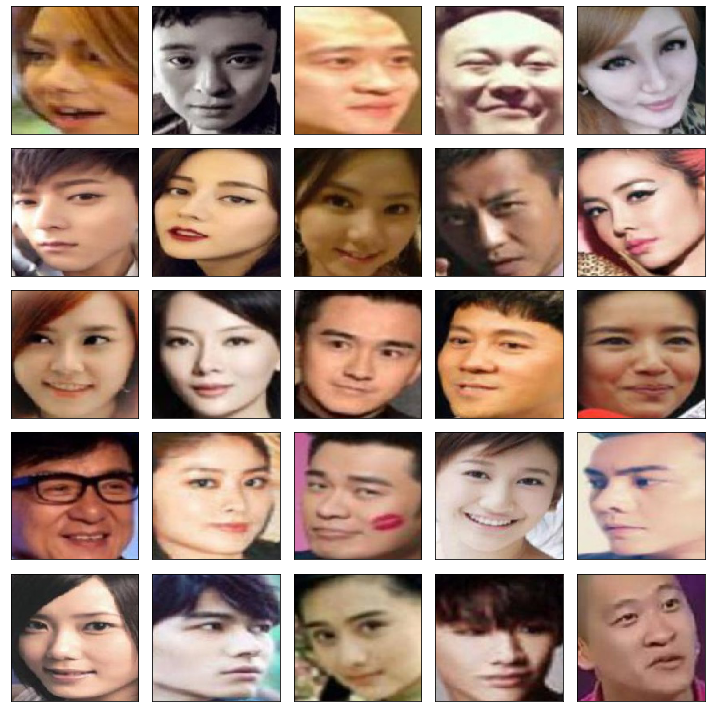

In [12]:
# Plotting face images
plt_img(face_img)

In [13]:
%%time

# Extracting HOG features of masked images 
hog_m_img = []
for image in masked_img[:8]:
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3, 3),visualize=True,multichannel = True)
    hog_m_img.append(hog_image)

hog_m_features = []
for image in masked_img:
    fd = hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3, 3),visualize=False,multichannel = True)
    hog_m_features.append(fd)

Wall time: 1min


In [14]:
# Function to plot HOG Features 

def plot_hog_img(img_arr,hog_arr):
    plt.figure(figsize=(10,10))
    for i in range(8):
        plt.subplot(4,4,i*2+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_arr[i])
        plt.subplot(4,4,i*2+2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(hog_arr[i],cmap=plt.cm.gray)
    plt.tight_layout()
#     plt.savefig("HOG_pics")
    plt.show()

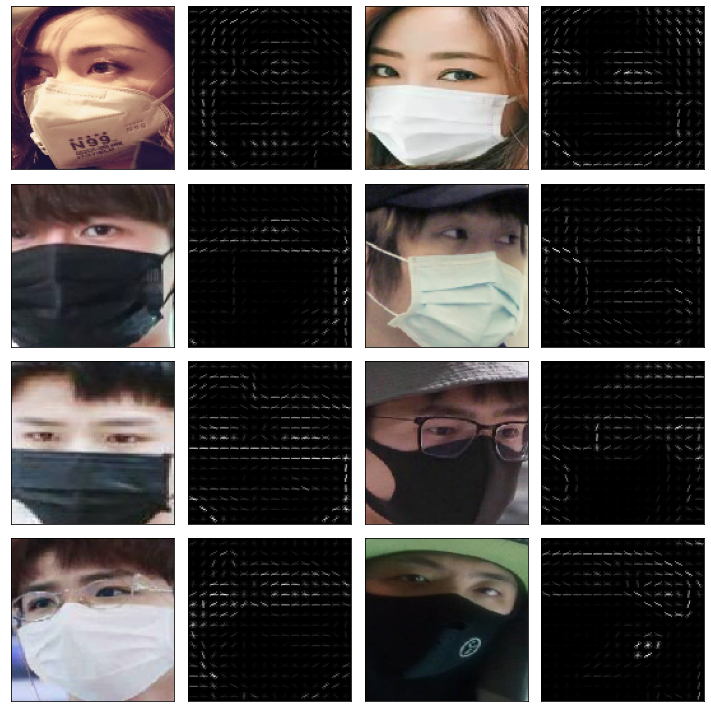

In [15]:
# Plotting HOG Features of masked images
plot_hog_img(masked_img,hog_m_img)

In [16]:
%%time

# Extracting HOG features of face images
hog_f_img = []
for image in face_img[:8]:
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3, 3),visualize=True,multichannel = True)
    hog_f_img.append(hog_image)

hog_f_features = []
for image in face_img:
    fd = hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3, 3),visualize=False ,multichannel = True)
    hog_f_features.append(fd)

Wall time: 58.5 s


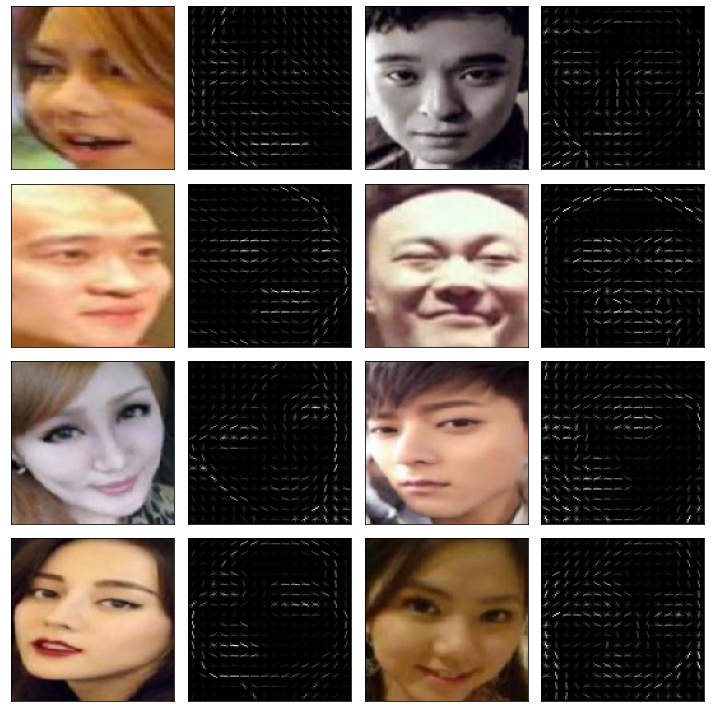

In [17]:
# Plotting HOG Features of masked images

plot_hog_img(face_img,hog_f_img)

In [18]:
# Function for calculating various performance metrics, AUC-ROC curve, and classification report

class_names = ['No Mask', 'Mask']
def print_result(actual,pred,pred_probab,picname='temp-aucroc'):
    #Classification Report
    print(classification_report(actual, pred,target_names=class_names))
    # Calculating False Positive Rate, True Positive rate and Threshold values
    fpr, tpr, thr = roc_curve(actual, pred_proba)
    metrics = {'Accuracy': accuracy_score(actual, pred),
              'Precision':precision_score(actual, pred),
              'Recall':recall_score(actual, pred),
              'Log Loss': log_loss(actual, pred_proba),
              'AUC': auc(fpr, tpr),
              'F1 Score':f1_score(actual, pred)
             }
    print("Accuracy = %2.3f" % metrics['Accuracy'])
    print("Precision = %2.3f" % metrics['Precision'])
    print("Recall = %2.3f" % metrics['Recall'])
    print("Log loss = %2.3f" % metrics['Log Loss'])
    print("AUC = %2.3f" % metrics['AUC'])
    print("F1 Score = %2.3f" % metrics['F1 Score'])
    #Plotting ROC-AUC curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()
    plt.savefig(picname)
    plt.show()
    return metrics
    
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [19]:
# Function to plot Confusion Matrix

def plot_conf_mtx(actual,pred, picname='temp-confmtx'):
    cf_matrix = confusion_matrix(actual, pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=0), yticklabels=class_names,
                xticklabels=class_names, annot=True,cmap='Blues',fmt=".2%")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(picname)
    plt.show()

In [20]:
# Dictionary to store results of various models
perf_metrics = {'SVM + HOG':{},'Linear SVM + HOG':{},'Random Forest + HOG':{},'SVM + Grayscale':{},
                'SVM + HOG + Grayscale':{},'Random Forest + HOG + Grayscale':{} }


## Splittng Data and Applying Various Models

In [21]:
# Combining HOG features into 1 list
X_list = hog_f_features + hog_m_features
X = np.array(X_list)
X.shape

(15170, 15876)

In [22]:
# Combining labels into 1 list

y_list = y_face + y_masked
y = np.array(y_list)
y.shape

(15170,)

In [23]:
# Train, Validation, and Test split into  80%, 10%, and 10%

x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=.2, random_state=2, stratify= y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=.5, random_state=2, stratify= y_val_test)

In [24]:
Counter(y_train),Counter(y_val),Counter(y_test)

(Counter({1: 6025, 0: 6111}),
 Counter({1: 753, 0: 764}),
 Counter({0: 764, 1: 753}))

In [25]:
# Appying GridSearch to find best hyperparameter 

# param_grid = {'C': [0.1, 1, 10, 100], 
#               'gamma': [1, 0.1, 0.01, 0.001],
#               } 
  
# grid = GridSearchCV(SVC(), param_grid, verbose = 3,n_jobs=-1)
  
# # fitting the model for grid search
# grid.fit(x_train, y_train)

## Model 1: SVM + HOG

              precision    recall  f1-score   support

     No Mask       0.99      0.96      0.98       764
        Mask       0.96      0.99      0.98       753

    accuracy                           0.98      1517
   macro avg       0.98      0.98      0.98      1517
weighted avg       0.98      0.98      0.98      1517

Accuracy = 0.976
Precision = 0.964
Recall = 0.988
Log loss = 0.368
AUC = 0.994
F1 Score = 0.976


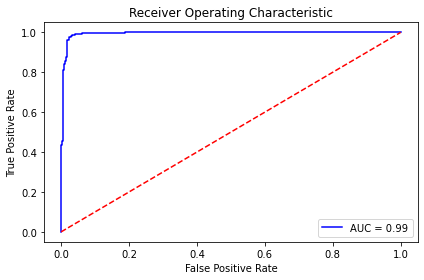

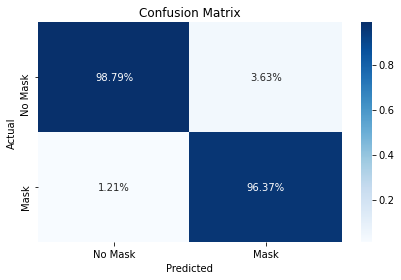

Wall time: 12min 7s


In [26]:
%%time

# Using SVM + HOG
svc_h = SVC()

# Fitting model on training set
# svc_h.fit(x_train, y_train)

# Loading the saved model
svc_h = pickle.load(open('svc_h', 'rb'))

# Predicting on validatation set
prediction = svc_h.predict(x_val)
pred_proba = svc_h.decision_function(x_val)

# printing various metrices and confusion matrix
# met = print_result(y_val,prediction,pred_proba,"aucroc-val-svc_h")
met = print_result(y_val,prediction,pred_proba)
perf_metrics['SVM + HOG']['val'] = met

# plot_conf_mtx(y_val,prediction,"confmtx-val-svc_h")
plot_conf_mtx(y_val,prediction)

In [27]:
# Saving model

# pickle.dump(svc_h, open('svc_h', 'wb'))

              precision    recall  f1-score   support

     No Mask       0.99      0.97      0.98       764
        Mask       0.97      0.99      0.98       753

    accuracy                           0.98      1517
   macro avg       0.98      0.98      0.98      1517
weighted avg       0.98      0.98      0.98      1517

Accuracy = 0.980
Precision = 0.969
Recall = 0.991
Log loss = 0.314
AUC = 0.995
F1 Score = 0.980


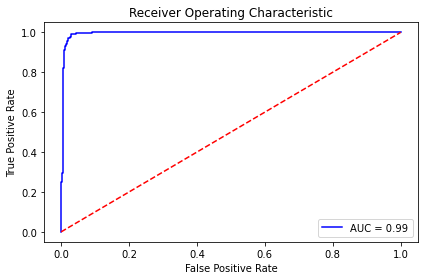

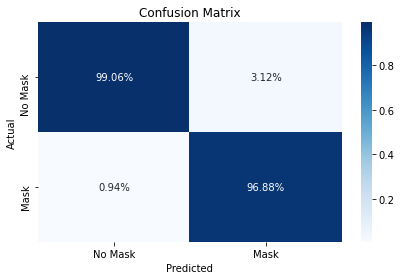

Wall time: 13min 22s


In [29]:
%%time

# Predicting on test set
prediction = svc_h.predict(x_test)
pred_proba = svc_h.decision_function(x_test)

# printing various metrices and confusion matrix
# met = print_result(y_test,prediction,pred_proba,"aucroc-test-svc_h")
met = print_result(y_test,prediction,pred_proba)

perf_metrics['SVM + HOG']['test'] = met

# plot_conf_mtx(y_test,prediction,"confmtx-test-svc_h")
plot_conf_mtx(y_test, prediction)

## Model 2: Linear SVM + HOG

              precision    recall  f1-score   support

     No Mask       0.98      0.96      0.97       764
        Mask       0.96      0.98      0.97       753

    accuracy                           0.97      1517
   macro avg       0.97      0.97      0.97      1517
weighted avg       0.97      0.97      0.97      1517

Accuracy = 0.968
Precision = 0.960
Recall = 0.977
Log loss = 0.655
AUC = 0.991
F1 Score = 0.968


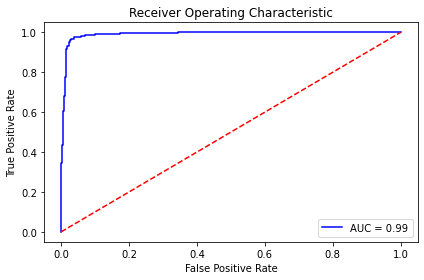

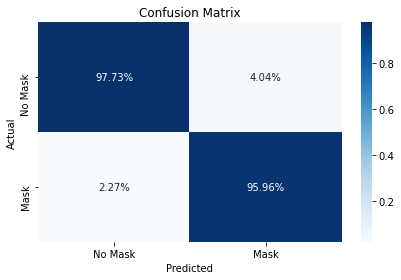

Wall time: 463 ms


In [30]:
%%time

# Using Linear SVM + HOG
lsvc_h = LinearSVC(C=2,max_iter=8000)

# Fitting model on training set
# lsvc_h.fit(x_train, y_train)

# Loading the saved model
lsvc_h = pickle.load(open('lsvc_h', 'rb'))

# Predicting on validatation set
prediction = lsvc_h.predict(x_val)
pred_proba = lsvc_h.decision_function(x_val)

# printing various metrices and confusion matrix
# met = print_result(y_val,prediction,pred_proba,"aucroc-val-lsvc_h")
met = print_result(y_val,prediction,pred_proba)

perf_metrics['Linear SVM + HOG']['val'] = met

# plot_conf_mtx(y_val,prediction,"confmtx-val-lsvc_h")
plot_conf_mtx(y_val,prediction)

In [31]:
# Saving model

# pickle.dump(lsvc_h, open('lsvc_h', 'wb'))

              precision    recall  f1-score   support

     No Mask       0.95      0.96      0.95       764
        Mask       0.95      0.95      0.95       753

    accuracy                           0.95      1517
   macro avg       0.95      0.95      0.95      1517
weighted avg       0.95      0.95      0.95      1517

Accuracy = 0.953
Precision = 0.955
Recall = 0.950
Log loss = 1.243
AUC = 0.989
F1 Score = 0.952


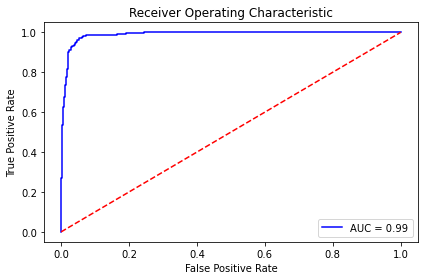

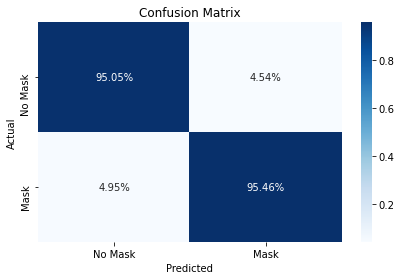

Wall time: 419 ms


In [32]:
%%time

# Predicting on test set
prediction = lsvc_h.predict(x_test)
pred_proba = lsvc_h.decision_function(x_test)

# printing various metrices and confusion matrix
# met = print_result(y_test,prediction,pred_proba,"aucroc-test-lsvc_h")
met = print_result(y_test,prediction,pred_proba)

perf_metrics['Linear SVM + HOG']['test'] = met
# plot_conf_mtx(y_test,prediction,"confmtx-test-lsvc_h")
plot_conf_mtx(y_test, prediction)

## Model 3: Random Forest + HOG

              precision    recall  f1-score   support

     No Mask       0.98      0.90      0.94       764
        Mask       0.91      0.98      0.95       753

    accuracy                           0.94      1517
   macro avg       0.95      0.94      0.94      1517
weighted avg       0.95      0.94      0.94      1517

Accuracy = 0.943
Precision = 0.910
Recall = 0.983
Log loss = 0.240
AUC = 0.987
F1 Score = 0.945


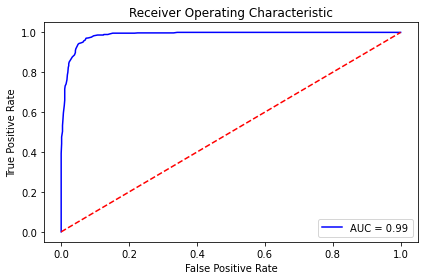

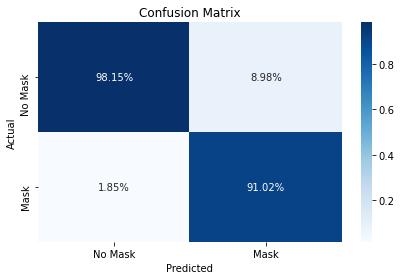

Wall time: 1.16 s


In [33]:
%%time

# Using Random Forest + HOG
rm_h = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Fitting model on training set
# rm_h.fit(x_train, y_train)

# Loading the saved model
rm_h = pickle.load(open('rm_h', 'rb'))

# Predicting on validatation set
prediction = rm_h.predict(x_val)
pred_proba = rm_h.predict_proba(x_val)[:,1]

# printing various metrices and confusion matrix
# met = print_result(y_val,prediction,pred_proba,"aucroc-val-rm_h")
met = print_result(y_val,prediction,pred_proba)

perf_metrics['Random Forest + HOG']['val'] = met

# plot_conf_mtx(y_val,prediction,"confmtx-val-rm_h")
plot_conf_mtx(y_val,prediction)

In [34]:
# Saving model

# pickle.dump(rm_h, open('rm_h', 'wb'))

              precision    recall  f1-score   support

     No Mask       0.98      0.92      0.95       764
        Mask       0.92      0.98      0.95       753

    accuracy                           0.95      1517
   macro avg       0.95      0.95      0.95      1517
weighted avg       0.95      0.95      0.95      1517

Accuracy = 0.951
Precision = 0.924
Recall = 0.983
Log loss = 0.231
AUC = 0.989
F1 Score = 0.952


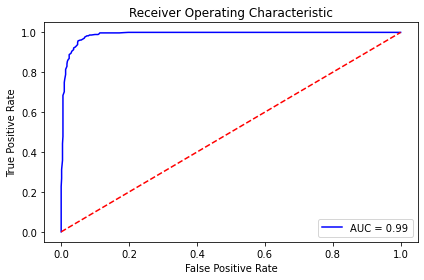

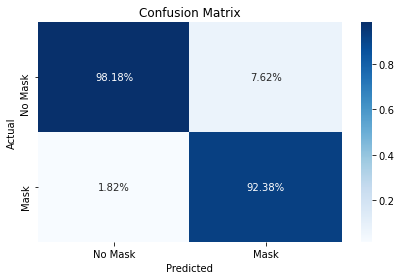

Wall time: 753 ms


In [35]:
%%time

# Predicting on test set
prediction = rm_h.predict(x_test)
pred_proba = rm_h.predict_proba(x_test)[:,1]

# printing various metrices and confusion matrix
# met = print_result(y_test,prediction,pred_proba,"aucroc-test-rm_h")
met = print_result(y_test,prediction,pred_proba)

perf_metrics['Random Forest + HOG']['test'] = met

# plot_conf_mtx(y_test,prediction,"confmtx-test-rm_h")
plot_conf_mtx(y_test, prediction)

In [36]:
# Converting RBG images to grayscale images

gray_m_img = []
gray_f_img = []

for image in masked_img:
    gray_m_img.append(rgb2gray(image))
    
for image in face_img:
    gray_f_img.append(rgb2gray(image))


In [37]:
# Splitting grayscale images into train, validation and test set with ratio 80, 10, 10 %

X_list_gray = gray_f_img + gray_m_img
X_gray = np.array(X_list_gray)
X_gray = X_gray.reshape(X_gray.shape[0],-1)
x_train, x_val_test, y_train, y_val_test = train_test_split(X_gray, y, test_size=.2, random_state=2, stratify= y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=.5, random_state=2, stratify= y_val_test)

## Model 4: SVM + GrayScale

              precision    recall  f1-score   support

     No Mask       0.94      0.93      0.93       764
        Mask       0.93      0.94      0.93       753

    accuracy                           0.93      1517
   macro avg       0.93      0.93      0.93      1517
weighted avg       0.93      0.93      0.93      1517

Accuracy = 0.933
Precision = 0.928
Recall = 0.939
Log loss = 1.340
AUC = 0.981
F1 Score = 0.933


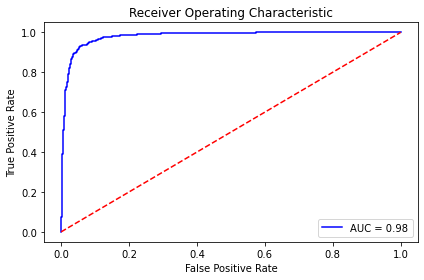

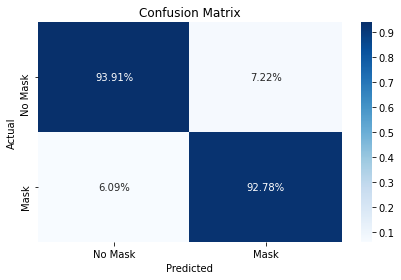

Wall time: 11min 52s


In [38]:
%%time

# Using SVM + Grayscale 
svc_g = SVC()

# Fitting model on training set
# svc_g.fit(x_train, y_train)

# Loading the saved model
svc_g = pickle.load(open('svc_g', 'rb'))

# Predicting on validatation set
prediction = svc_g.predict(x_val)
pred_proba = svc_g.decision_function(x_val)

# printing various metrices and confusion matrix
# met = print_result(y_val,prediction,pred_proba,"aucroc-val-svc_g")
met = print_result(y_val,prediction,pred_proba)

perf_metrics['SVM + Grayscale']['val'] = met

# plot_conf_mtx(y_val,prediction,"confmtx-val-svc_g")
plot_conf_mtx(y_val,prediction)

In [39]:
# Saving model

# pickle.dump(svc_g, open('svc_g', 'wb'))

              precision    recall  f1-score   support

     No Mask       0.94      0.93      0.93       764
        Mask       0.93      0.94      0.93       753

    accuracy                           0.93      1517
   macro avg       0.93      0.93      0.93      1517
weighted avg       0.93      0.93      0.93      1517

Accuracy = 0.933
Precision = 0.930
Recall = 0.936
Log loss = 1.383
AUC = 0.981
F1 Score = 0.933


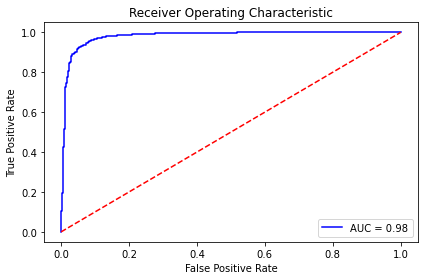

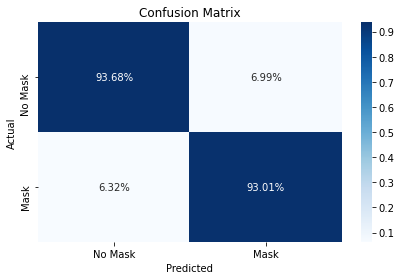

Wall time: 15min 51s


In [40]:
%%time

# Predicting on test set
prediction = svc_g.predict(x_test)
pred_proba = svc_g.decision_function(x_test)

# printing various metrices and confusion matrix
# met = print_result(y_test,prediction,pred_proba,"aucroc-test-svc_g")
met = print_result(y_test,prediction,pred_proba)

perf_metrics['SVM + Grayscale']['test'] = met

# plot_conf_mtx(y_test,prediction,"confmtx-test-svc_g")
plot_conf_mtx(y_test, prediction)

In [41]:
# Extracting HOG features of grayscale masked images

hog_m_img_gray = []
hog_m_features_gray = []
for image in gray_m_img:
    fd = hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3, 3),visualize=False)
    hog_m_features_gray.append(fd)

In [42]:
# Extracting HOG features of grayscale face images

hog_f_img_gray = []
hog_f_features_gray = []
for image in gray_f_img:
    fd = hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3, 3),visualize=False)
    hog_f_features_gray.append(fd)

In [43]:
# Splitting HOG Features into train, validation and test set with ratio 80, 10, 10%

X_list_gray = hog_f_features_gray + hog_m_features_gray

X_gray = np.array(X_list_gray)
x_train, x_val_test, y_train, y_val_test = train_test_split(X_gray, y, test_size=.2, random_state=2, stratify= y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=.5, random_state=2, stratify= y_val_test)

## Model 5: SVM + HOG + Grayscale

              precision    recall  f1-score   support

     No Mask       0.99      0.96      0.97       764
        Mask       0.96      0.99      0.97       753

    accuracy                           0.97      1517
   macro avg       0.97      0.97      0.97      1517
weighted avg       0.97      0.97      0.97      1517

Accuracy = 0.974
Precision = 0.961
Recall = 0.987
Log loss = 0.390
AUC = 0.994
F1 Score = 0.974


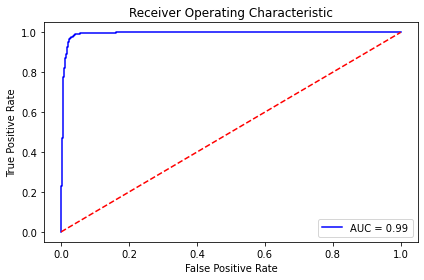

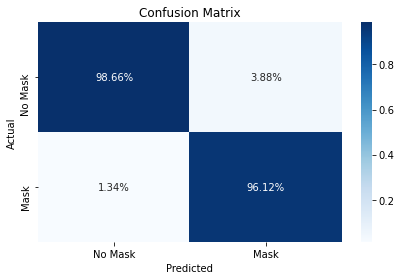

Wall time: 13min 54s


In [44]:
%%time

# Using SVM + HOG + Grayscale
svc_h_g = SVC()

# Fitting model on training set
# svc_h_g.fit(x_train, y_train)

# Loading the saved model
svc_h_g = pickle.load(open('svc_h_g_v2', 'rb'))

# Predicting on validatation set
prediction = svc_h_g.predict(x_val)
pred_proba = svc_h_g.decision_function(x_val)

# printing various metrices and confusion matrix
# met = print_result(y_val,prediction,pred_proba,"aucroc-val-svc_h_g")
met = print_result(y_val,prediction,pred_proba)


perf_metrics['SVM + HOG + Grayscale']['val'] = met
# plot_conf_mtx(y_val,prediction,"confmtx-val-svc_h_g")
plot_conf_mtx(y_val,prediction)

In [45]:
# Saving model

# pickle.dump(svc_h_g, open('svc_h_g_v2', 'wb'))

              precision    recall  f1-score   support

     No Mask       0.99      0.96      0.98       764
        Mask       0.96      0.99      0.98       753

    accuracy                           0.98      1517
   macro avg       0.98      0.98      0.98      1517
weighted avg       0.98      0.98      0.98      1517

Accuracy = 0.977
Precision = 0.963
Recall = 0.992
Log loss = 0.317
AUC = 0.994
F1 Score = 0.977


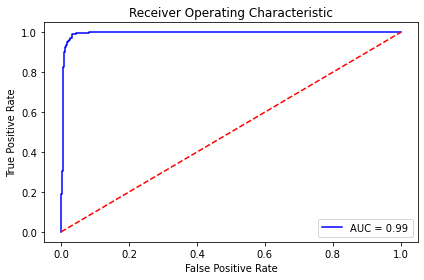

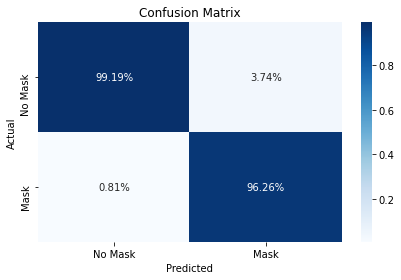

Wall time: 13min 38s


In [46]:
%%time

# Predicting on validatation set
prediction = svc_h_g.predict(x_test)
pred_proba = svc_h_g.decision_function(x_test)

# printing various metrices and confusion matrix
# met = print_result(y_test,prediction,pred_proba,"aucroc-test-svc_h_g")
met = print_result(y_test,prediction,pred_proba)

perf_metrics['SVM + HOG + Grayscale']['test'] = met
# plot_conf_mtx(y_test,prediction,"confmtx-test-svc_h_g")
plot_conf_mtx(y_test, prediction)

## Model 6: Random Forest + HOG + Grayscale

              precision    recall  f1-score   support

     No Mask       0.97      0.91      0.94       764
        Mask       0.92      0.98      0.95       753

    accuracy                           0.94      1517
   macro avg       0.95      0.94      0.94      1517
weighted avg       0.95      0.94      0.94      1517

Accuracy = 0.945
Precision = 0.918
Recall = 0.976
Log loss = 0.245
AUC = 0.985
F1 Score = 0.946


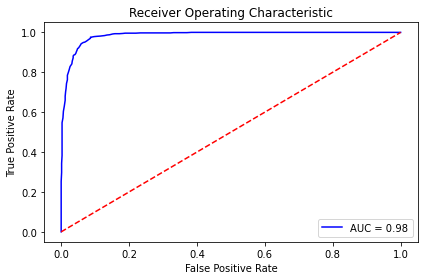

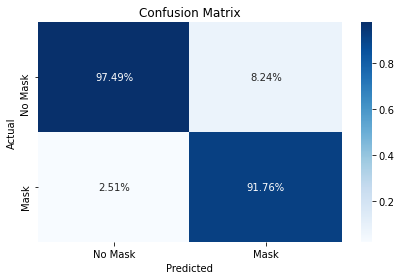

Wall time: 1.15 s


In [47]:
%%time

# Using Random Forest + HOG + Grayscale
rm_h_g = RandomForestClassifier(n_jobs=-1)

# Fitting model on training set
# rm_h_g.fit(x_train, y_train)

# Loading the saved model
rm_h_g = pickle.load(open('rm_h_g', 'rb'))

# Predicting on validatation set
prediction = rm_h_g.predict(x_val)
pred_proba = rm_h_g.predict_proba(x_val)[:,1]

# printing various metrices and confusion matrix
# met = print_result(y_val,prediction,pred_proba,"aucroc-val-rm_h_g")
met = print_result(y_val,prediction,pred_proba)


perf_metrics['Random Forest + HOG + Grayscale']['val'] = met
# plot_conf_mtx(y_val,prediction,"confmtx-val-rm_h_g")
plot_conf_mtx(y_val,prediction)

In [48]:
# Saving model

# pickle.dump(rm_h_g, open('rm_h_g', 'wb'))

              precision    recall  f1-score   support

     No Mask       0.98      0.92      0.95       764
        Mask       0.92      0.98      0.95       753

    accuracy                           0.95      1517
   macro avg       0.95      0.95      0.95      1517
weighted avg       0.95      0.95      0.95      1517

Accuracy = 0.951
Precision = 0.923
Recall = 0.983
Log loss = 0.236
AUC = 0.989
F1 Score = 0.952


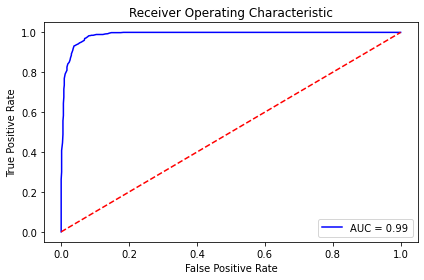

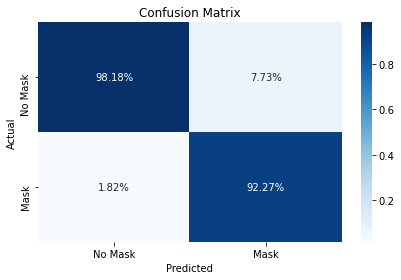

Wall time: 841 ms


In [49]:
%%time

# Predicting on test set
prediction = rm_h_g.predict(x_test)
pred_proba = rm_h_g.predict_proba(x_test)[:,1]

# printing various metrices and confusion matrix
# met = print_result(y_test,prediction,pred_proba,"aucroc-test-rm_h_g")
met = print_result(y_test,prediction,pred_proba)

perf_metrics['Random Forest + HOG + Grayscale']['test'] = met
# plot_conf_mtx(y_test,prediction,"confmtx-test-rm_h_g")
plot_conf_mtx(y_test, prediction)

In [50]:
# Splitting RGB images into train, validation, and test set with ratio 80, 10, 10%

X_img = face_img + masked_img
X_img = np.asarray(X_img)

x_train, x_val_test, y_train, y_val_test = train_test_split(X_img, y, test_size=.2, random_state=2, stratify= y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=.5, random_state=2, stratify= y_val_test)

In [51]:
# Function to plot Loss and Accuracy 

def plt_acc_loss(history):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.ylim([0.8,1])
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.subplot(122)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.ylim([0,0.5])
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig("acc_loss-mobilenetv2")
    plt.show()

# Model 7: MobileNetV2 - Transfer Learning

In [179]:
# architechture is In -> MobileNetV2 -> Dense -> Dense -> Out

model = Sequential()
model.add(hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/5",trainable=True))
# model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.build([None, 128, 128, 3])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_20 (Dense)             (None, 64)                81984     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 2,340,033
Trainable params: 2,305,921
Non-trainable params: 34,112
_________________________________________________________________


In [180]:
# Compiling Model
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [181]:
# Training Model
history = model.fit(x_train, y_train, batch_size=64, epochs=30,  
                    validation_data = (x_val, y_val))

Epoch 1/30
190/190 [==============================] - 38s 162ms/step - loss: 0.1602 - accuracy: 0.9608 - val_loss: 0.1786 - val_accuracy: 0.9618
Epoch 2/30
190/190 [==============================] - 30s 156ms/step - loss: 0.0914 - accuracy: 0.9955 - val_loss: 0.0914 - val_accuracy: 0.9960
Epoch 3/30
190/190 [==============================] - 30s 157ms/step - loss: 0.0886 - accuracy: 0.9966 - val_loss: 0.1200 - val_accuracy: 0.9868
Epoch 4/30
190/190 [==============================] - 30s 159ms/step - loss: 0.0951 - accuracy: 0.9952 - val_loss: 0.0857 - val_accuracy: 0.9980
Epoch 5/30
190/190 [==============================] - 31s 161ms/step - loss: 0.0792 - accuracy: 0.9984 - val_loss: 0.1120 - val_accuracy: 0.9888
Epoch 6/30
190/190 [==============================] - 30s 156ms/step - loss: 0.0841 - accuracy: 0.9963 - val_loss: 0.0822 - val_accuracy: 0.9980
Epoch 7/30
190/190 [==============================] - 30s 158ms/step - loss: 0.0788 - accuracy: 0.9971 - val_loss: 0.0871 - val_ac

In [192]:
# Loading the model

# model =  tf.keras.models.load_model(('FaceMask-MobileNetV2-v6.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

In [193]:
# Testing Model
model.evaluate(x_test,  y_test, verbose=2)

48/48 - 2s - loss: 0.0438 - accuracy: 0.9974


[0.04377594217658043, 0.9973632097244263]

In [184]:
# Saving the model

# model.save("FaceMask-MobileNetV2-v6.h5")

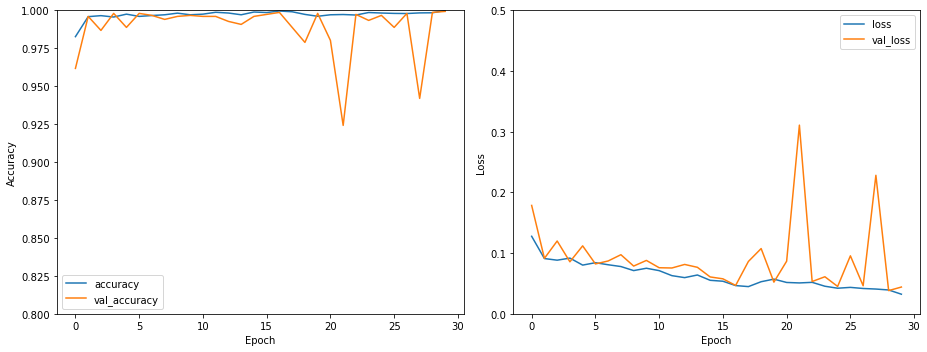

In [185]:
# Plotting the accuracy-loss graph
plt_acc_loss(history)

              precision    recall  f1-score   support

     No Mask       0.99      0.99      0.99       764
        Mask       0.99      0.99      0.99       753

    accuracy                           0.99      1517
   macro avg       0.99      0.99      0.99      1517
weighted avg       0.99      0.99      0.99      1517

Accuracy = 0.995
Precision = 0.995
Recall = 0.995
Log loss = 0.018
AUC = 1.000
F1 Score = 0.995


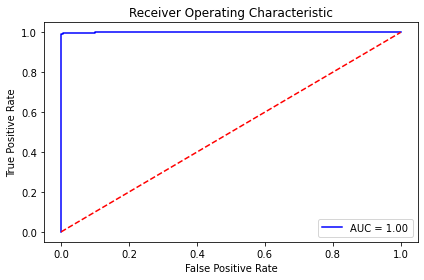

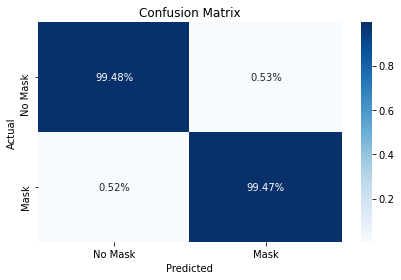

Wall time: 2.04 s


In [204]:
%%time 

# Predicting on validatation set

prediction = (model.predict(x_val) > 0.5).astype("int32")
pred_proba = model.predict(x_val)

# printing various metrices and confusion matrix
perf_metrics['MobileNetV2'] = {}
met = print_result(y_val,prediction,pred_proba)
# met = print_result(y_val,prediction,pred_proba,"aucroc-val-MobileNetV2")

perf_metrics['MobileNetV2']['val'] = met

plot_conf_mtx(y_val,prediction)
# plot_conf_mtx(y_val,prediction,"confmtx-val-MobileNetV2")

## Evaluation of all the Models 

              precision    recall  f1-score   support

     No Mask       1.00      1.00      1.00       764
        Mask       1.00      1.00      1.00       753

    accuracy                           1.00      1517
   macro avg       1.00      1.00      1.00      1517
weighted avg       1.00      1.00      1.00      1517

Accuracy = 0.997
Precision = 0.999
Recall = 0.996
Log loss = 0.012
AUC = 1.000
F1 Score = 0.997


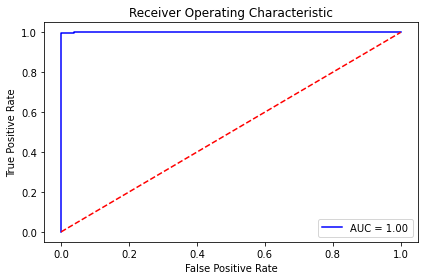

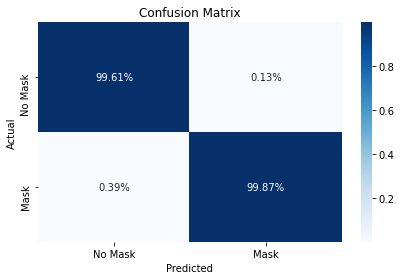

Wall time: 2.03 s


In [205]:
%%time

# Predicting on test set

prediction = (model.predict(x_test) > 0.5).astype("int32")
pred_proba = model.predict(x_test)

# printing various metrices and confusion matrix
met = print_result(y_test,prediction,pred_proba)
# met = print_result(y_test,prediction,pred_proba,"aucroc-test-MobileNetV2")

perf_metrics['MobileNetV2']['test'] = met

plot_conf_mtx(y_test,prediction)
# plot_conf_mtx(y_test,prediction,"confmtx-test-MobileNetV2")

In [203]:
# Serialize data into file:
# json.dump( perf_metrics, open( "perf_metrics-v3.json", 'w' ), indent = 4 )

# Read data from file:
# perf_metrics = json.load( open( "perf_metrics.json" ) )

In [197]:
# Composite Table of various performance metrics for different model

reform = {(level1_key, level2_key): values
         for level1_key, level2_dict in perf_metrics.items()
           for level2_key, values in level2_dict.items()
           }
pd.DataFrame(reform).T.round(3)

Accuracy  Precision  Recall  Log Loss  \
SVM + HOG                       val      0.976      0.964   0.988     0.368   
                                test     0.980      0.969   0.991     0.314   
Linear SVM + HOG                val      0.968      0.960   0.977     0.655   
                                test     0.953      0.955   0.950     1.243   
Random Forest + HOG             val      0.943      0.910   0.983     0.240   
                                test     0.951      0.924   0.983     0.231   
SVM + Grayscale                 val      0.933      0.928   0.939     1.340   
                                test     0.933      0.930   0.936     1.383   
SVM + HOG + Grayscale           val      0.974      0.961   0.987     0.390   
                                test     0.977      0.963   0.992     0.317   
Random Forest + HOG + Grayscale val      0.945      0.918   0.976     0.245   
                                test     0.951      0.923   0.983     0.236   
MobileNetV2                     val      0.995      0.995   0.995     0.018   
                                test     0.997      0.999   0.996     0.012   

                                        AUC  F1 Score  
SVM + HOG                       val   0.994     0.976  
                                test  0.995     0.980  
Linear SVM + HOG                val   0.991     0.968  
                                test  0.989     0.952  
Random Forest + HOG             val   0.987     0.945  
                                test  0.989     0.952  
SVM + Grayscale                 val   0.981     0.933  
                                test  0.981     0.933  
SVM + HOG + Grayscale           val   0.994     0.974  
                                test  0.994     0.977  
Random Forest + HOG + Grayscale val   0.985     0.946  
                                test  0.989     0.952  
MobileNetV2                     val   1.000     0.995  
                                test  1.000     0.997

In [198]:
# Composite Table of various performance metrics for different model - on validation set

reform = {level1_key: level2_dict['val']
         for level1_key, level2_dict in perf_metrics.items()
           }
pd.DataFrame(reform).T.round(3)

,Accuracy,Precision,Recall,Log Loss,AUC,F1 Score
SVM + HOG,0.976,0.964,0.988,0.368,0.994,0.976
Linear SVM + HOG,0.968,0.960,0.977,0.655,0.991,0.968
Random Forest + HOG,0.943,0.910,0.983,0.240,0.987,0.945
SVM + Grayscale,0.933,0.928,0.939,1.340,0.981,0.933
SVM + HOG + Grayscale,0.974,0.961,0.987,0.390,0.994,0.974
Random Forest + HOG + Grayscale,0.945,0.918,0.976,0.245,0.985,0.946
MobileNetV2,0.995,0.995,0.995,0.018,1.000,0.995


In [199]:
# Composite Table of various performance metrics for different model - on test set

reform = {level1_key: level2_dict['test']
         for level1_key, level2_dict in perf_metrics.items()
         }
pd.DataFrame(reform).T.round(3)

,Accuracy,Precision,Recall,Log Loss,AUC,F1 Score
SVM + HOG,0.980,0.969,0.991,0.314,0.995,0.980
Linear SVM + HOG,0.953,0.955,0.950,1.243,0.989,0.952
Random Forest + HOG,0.951,0.924,0.983,0.231,0.989,0.952
SVM + Grayscale,0.933,0.930,0.936,1.383,0.981,0.933
SVM + HOG + Grayscale,0.977,0.963,0.992,0.317,0.994,0.977
Random Forest + HOG + Grayscale,0.951,0.923,0.983,0.236,0.989,0.952
MobileNetV2,0.997,0.999,0.996,0.012,1.000,0.997


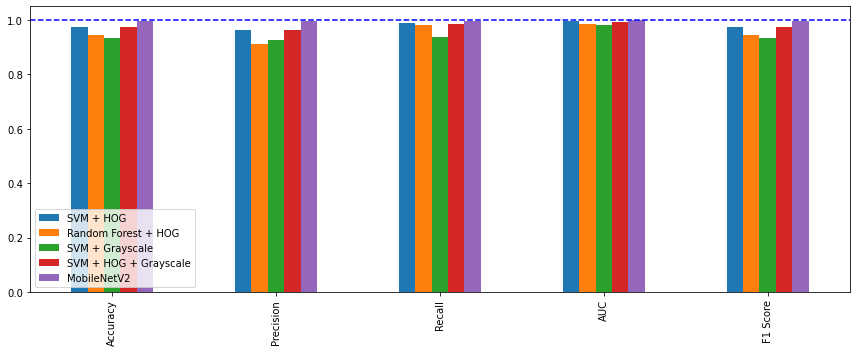

In [202]:
# bar chart of performance on validation set 

reform = {level1_key: level2_dict['val']
         for level1_key, level2_dict in perf_metrics.items()
           }
bar_df = pd.DataFrame(reform).drop('Log Loss')
bar_df.drop(columns=[bar_df.columns[1],bar_df.columns[5]],inplace=True)
bar_df.plot(kind='bar',figsize=(12,5))
plt.axhline(y=1.0, color='b', linestyle='--')
plt.tight_layout()
# plt.savefig("Val-perf-bar")
plt.show()

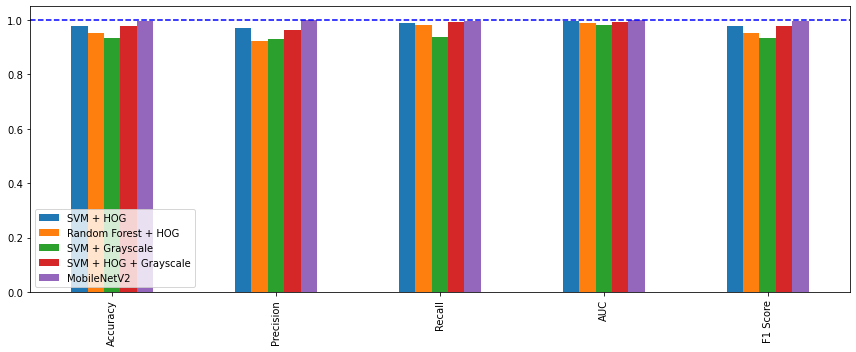

In [201]:
# bar chart of performance on test set 

reform = {level1_key: level2_dict['test']
         for level1_key, level2_dict in perf_metrics.items()
         }
bar_df = pd.DataFrame(reform).drop('Log Loss')
bar_df.drop(columns=[bar_df.columns[1],bar_df.columns[5]],inplace=True)
bar_df.plot(kind='bar',figsize=(12,5))
plt.axhline(y=1.0, color='b', linestyle='--')
plt.tight_layout()
# plt.savefig("test-perf-bar")
plt.show()

## Real Time Face Detection

In [101]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # Loading Haar Cascade

## Face Detection using SVM Model

In [103]:
# Loading the saved model
m_file_name ='lsvc_h'
# m_file_name ='svc_h'
svm_model = pickle.load(open(m_file_name, 'rb'))

In [112]:

is_Mask = {0: 'No Mask', 1: 'Mask'}
bbox_color = {0: (0,0,255), 1: (0,255,0)}

# To capture video from webcam. 
# cap = cv2.VideoCapture(0)

# To use a video file as input 
cap = cv2.VideoCapture('temp-mask-5.mp4')

while True:
    # Read the frame
    retval, img = cap.read()
    
    if not retval: break;
        
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 4,minSize=(30,30))
    
    # Draw the rectangle around each face - Green if Mask and Red if No Mask
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w] if m_file_name == 'svc_h_g_v2' else img[y:y+h, x:x+w] # Cropping face 
#         face = gray[y:y+h, x:x+w]
#         face = img[y:y+h, x:x+w]
        face = cv2.resize(face,(128,128)) # resizing into desired input dimension of 128x128
        face = face/255. # Normalizing the image array
        face_hog = hog(face, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3, 3),visualize=False) # Extracting HOG Features
        face_hog = np.asarray(face_hog).reshape(1,-1)
        f_pred = svm_model.predict(face_hog) # Predicting the label - mask-1 or no mask-0
        f_pred_proba = svm_model.decision_function(face_hog) 
        cv2.rectangle(img,(x,y),(x+w,y+h),bbox_color[f_pred[0]],2) # Drawing a rectangle around the face
        cv2.putText(img,f'{is_Mask[f_pred[0]]} {50 + np.clip(f_pred_proba,-1,1)[0]*100/2:.2f}%',(x,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,0.8,bbox_color[f_pred[0]], 2) # Putting text above the rectangle
    cv2.imshow('Video',img) # showing the video output
    
     # Stop if 'q' key is pressed
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
        

## Face Detection using MobileNetV2

In [68]:
# Loading the saved model
detection_model =  tf.keras.models.load_model(('FaceMask-MobileNetV2-v3.h5'),custom_objects={'KerasLayer':hub.KerasLayer})
model = detection_model

In [111]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

is_Mask = {0: 'No Mask', 1: 'Mask'}
bbox_color = {0: (0,0,255), 1: (0,255,0)}

# To capture video from webcam. 
# cap = cv2.VideoCapture(0)

# To use a video file as input 
cap = cv2.VideoCapture('temp-mask.mp4')

while True:
    # Read the frame
    retval, img = cap.read()
    
    if not retval: break;
        
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 4,minSize=(60,60))
    
    # Draw the rectangle around each face - Green if Mask and Red if No Mask
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w] # Cropping face 
        face = cv2.resize(face,(128,128)) # resizing into desired input dimension of 128x128
        face = face/255.  # Normalizing the image array
        input_arr = img_to_array(face)
        input_arr = np.array([input_arr])  # Convert single image to required input shape
        f_pred = (model.predict(input_arr) > 0.5).astype("int32") # Predicting the label - mask-1 or no mask-0
        f_pred_proba = model.predict(input_arr) # Storing probability of the face with mask

        cv2.rectangle(img,(x,y),(x+w,y+h),bbox_color[f_pred[0][0]],2) # Drawing a rectangle around the face
        cv2.putText(img,f'{is_Mask[f_pred[0][0]]} {f_pred_proba[0][0]*100:.2f}%',(x,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,0.8,bbox_color[f_pred[0][0]], 2) # Putting text above the rectangle
    cv2.imshow('Video',img) # showing the video output
    
     # Stop if q key is pressed
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
        